# Benchmark Specific Visualization

In [1]:
import glob
import gzip
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from modelproblem import ModelProblem
from petab.visualize import plot_problem
from weighted_quantile import weighted_quantile
from result_classes import Result,MethodResults

In [2]:
prob_name = "Boehm_JProteomeRes2014"
methods = ["ptmcmc", "smc"]#, "pmc"]
colors = sns.color_palette("tab10", n_colors=len(methods))

mod_prob = ModelProblem(prob_name)
mod_prob.initialize()

grouped_results = [MethodResults(x) for x in methods]

for method, group_obj in zip(methods, grouped_results):
	result_dir = f"results/{prob_name}/{method}/"
	fnames = glob.glob(result_dir + "*.pkl")
	for fname in fnames:
		#print(fname)
		with gzip.open(fname, "rb") as f:
			results = pickle.load(f)
		result_obj = Result(results)
		group_obj.add_result(result_obj)
print(type(mod_prob.problem))

The location of the model directory is: /home/larkinit/anaconda3/envs/test1/lib/python3.12/site-packages/benchmark_models_petab/Benchmark-Models
<class 'pypesto.problem.base.Problem'>


Text(0, 0.5, 'Sampling Quality (log_k1)')

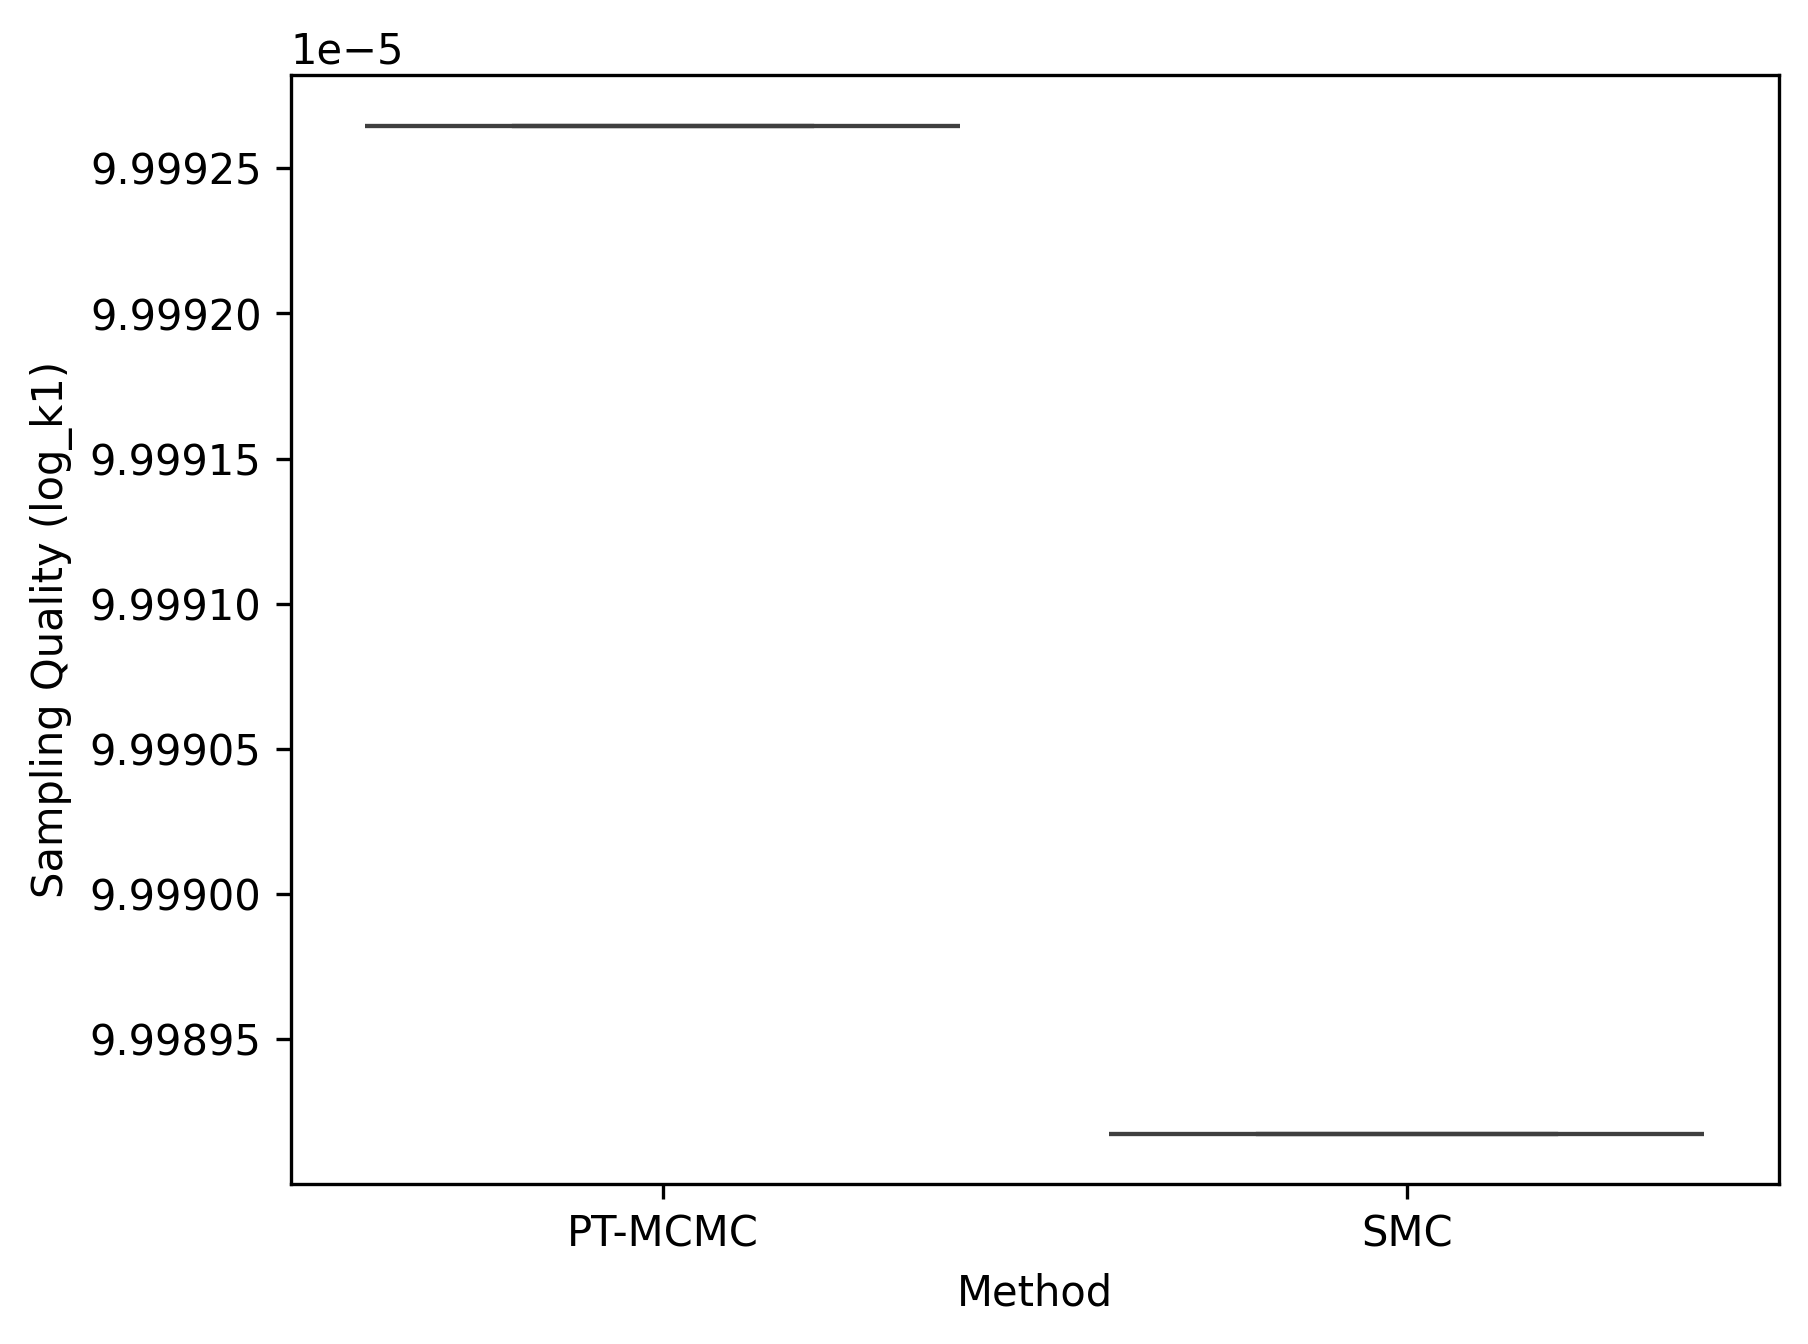

In [3]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 0) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); plt.ylabel("Sampling Quality (log_k1)")
#plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[0]} ");

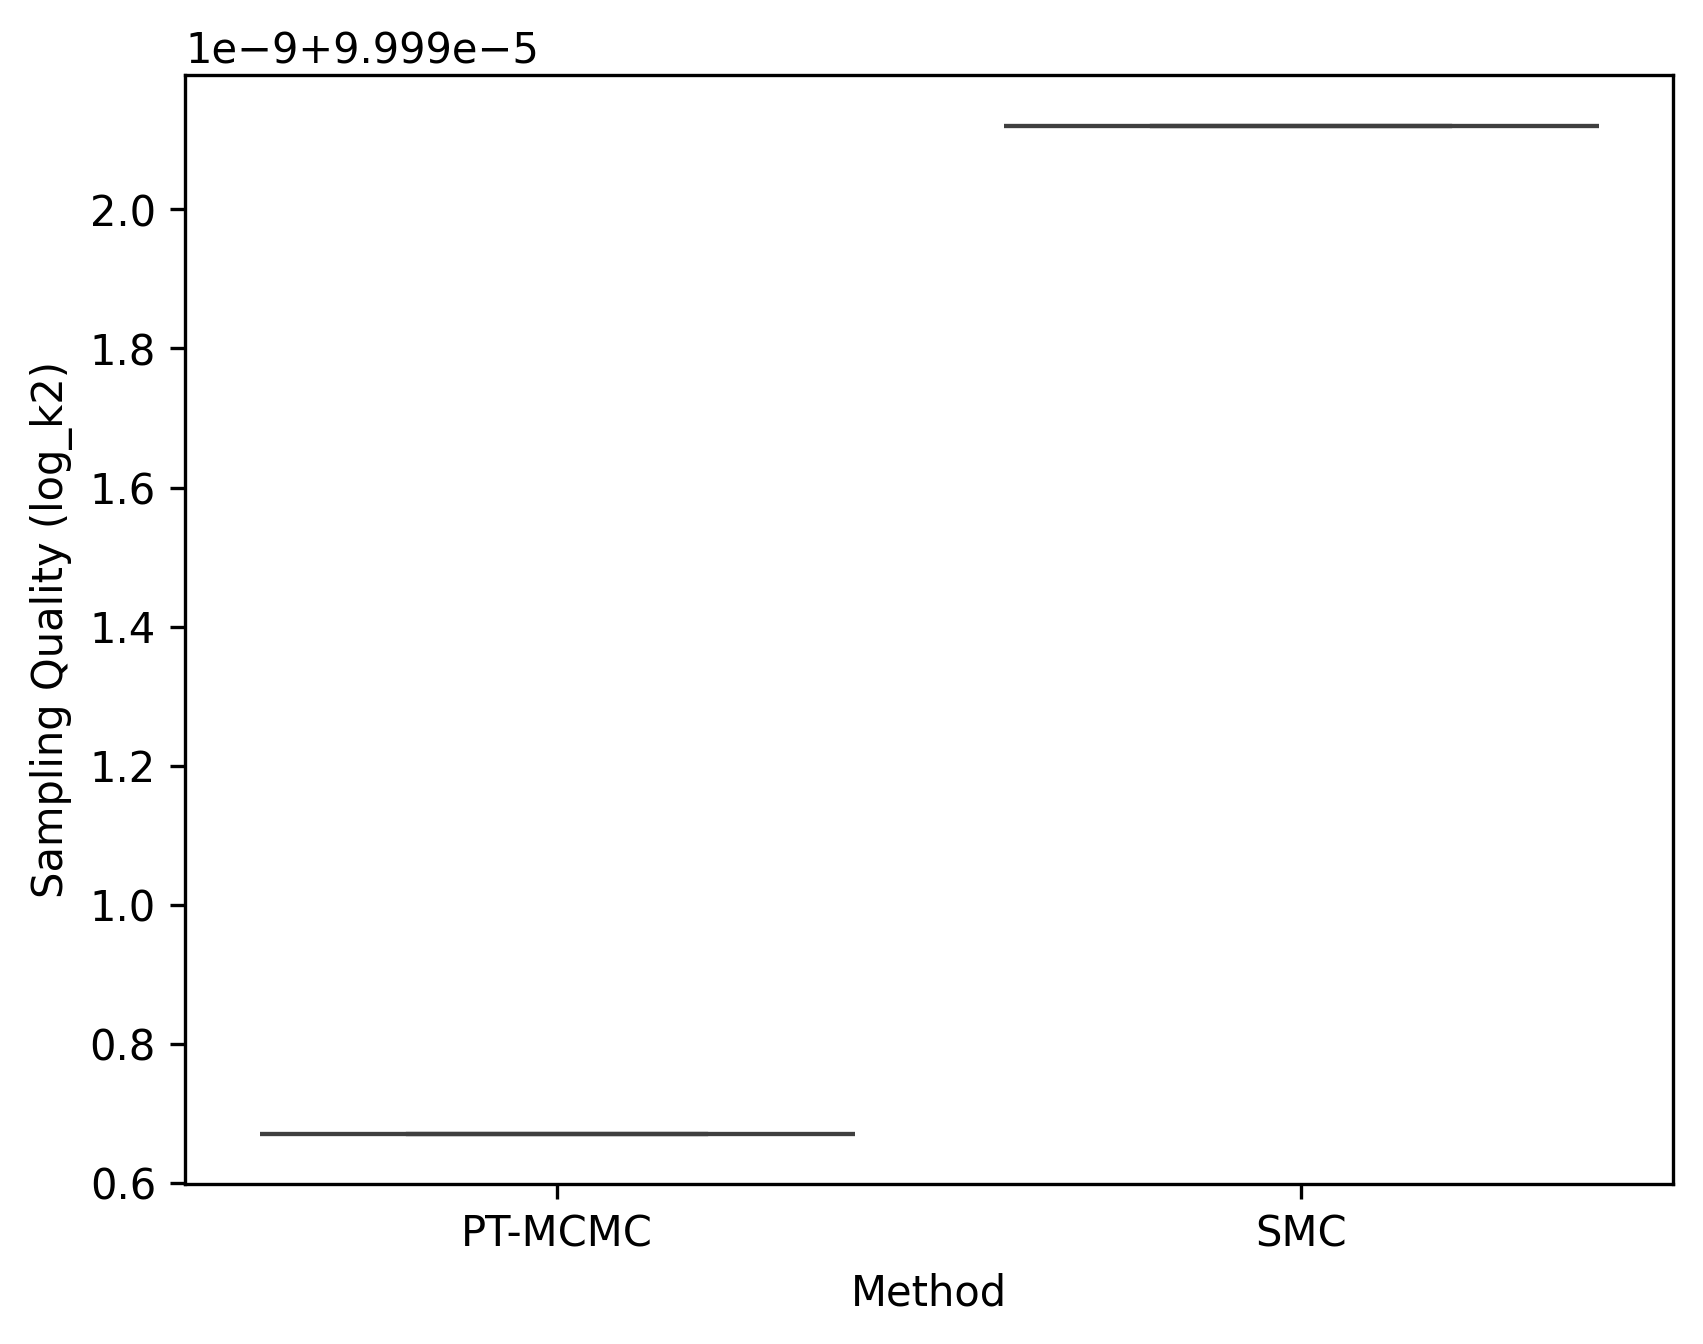

In [4]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300)
ratios = np.array([x.get_sampling_efficiency(par_bounds, 1) for x in grouped_results])
ratio_df = pd.DataFrame(columns=methods, data=ratios.T)

sns.boxplot(ratio_df)#, size=2)
plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
plt.xlabel("Method"); #plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[1]} ");
plt.ylabel("Sampling Quality (log_k2)");

In [5]:

fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]
par_bounds = mod_prob.bounds
plt.figure(dpi=300, figsize=(6,4))

df = pd.DataFrame(columns=["Method", "Parameter", "Ratio"])
for i, group in enumerate(grouped_results):
	ratios = np.array(group.get_sampling_efficiency(par_bounds, 0))
	temp = pd.DataFrame({"Parameter":["log_k1"]*100, "Method":[group.abbr]*100,"Ratio":ratios})
	df = pd.concat([df,temp],ignore_index=True)
	ratios1 = np.array(group.get_sampling_efficiency(par_bounds, 1))
	temp1 = pd.DataFrame({"Parameter":["log_k2"]*100, "Method":[group.abbr]*100,"Ratio":ratios})
	df = pd.concat([df,temp1],ignore_index=True)


sns.boxplot(data=df, x="Parameter", y="Ratio", hue="Method")
#plt.xticks(range(len(methods)), [x.abbr for x in grouped_results])
#plt.xlabel("Method"); #plt.ylabel(f"% of Parameter Space Covered\nfor Parameter {fit_par_names[1]} ");
plt.ylabel("Sampling Quality");

ValueError: All arrays must be of the same length

<Figure size 1800x1200 with 0 Axes>

## Select best result for each method

In [6]:
llhs = [x.get_avg_llhs() for x in grouped_results]
best_runs = [np.argmax(x) for x in llhs]
best_results = [res.all_runs[best_idx] for best_idx, res in zip(best_runs, grouped_results)]

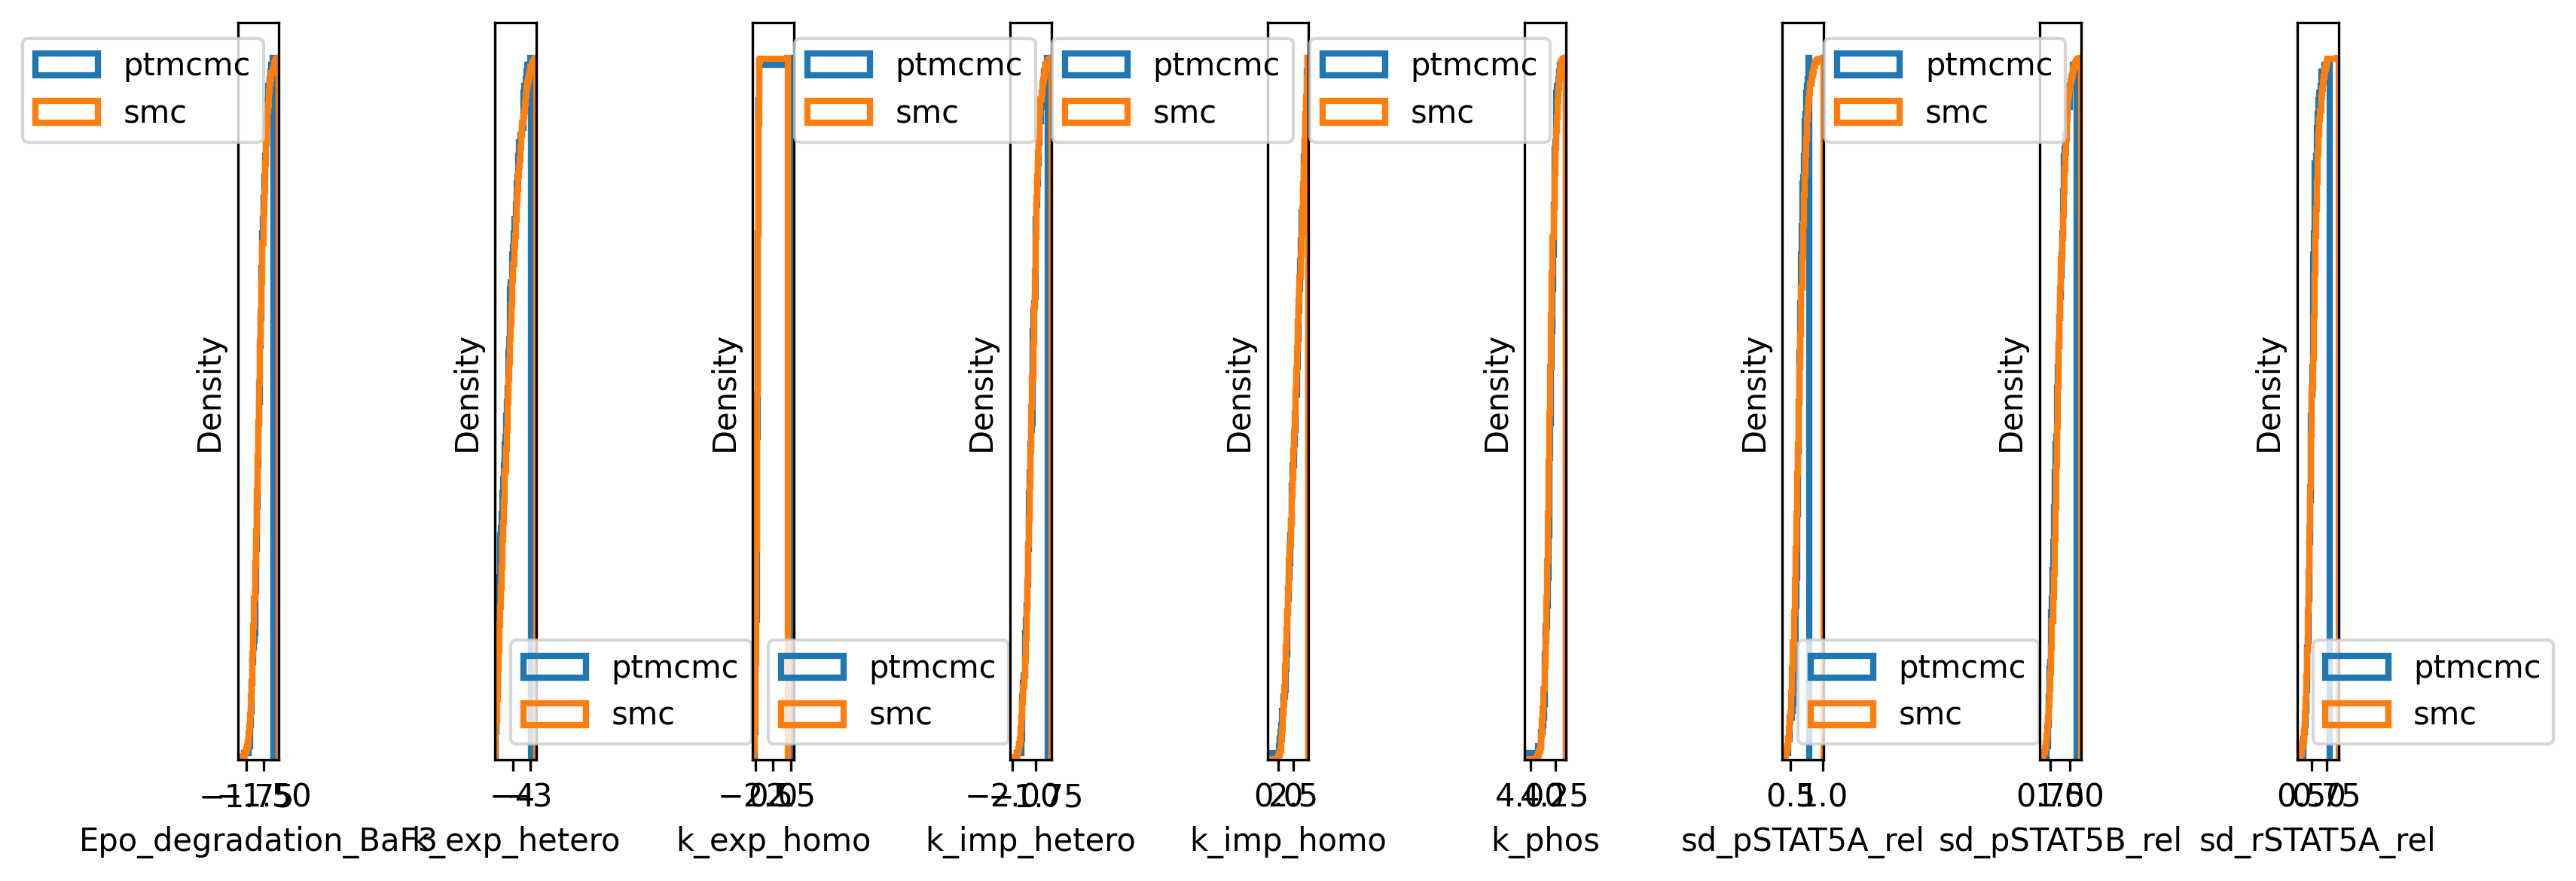

In [7]:
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "step"
alpha=1

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		norm_ws = cur_result.posterior_weights
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=norm_ws, color=colors[j], alpha=alpha,
			 cumulative=True, histtype="step", bins=50, label=cur_result.method) 
		plt.xlabel(par_name)
		plt.yticks([])
		plt.ylabel("Density")
		plt.margins(x=0)
	plt.legend()
plt.tight_layout()

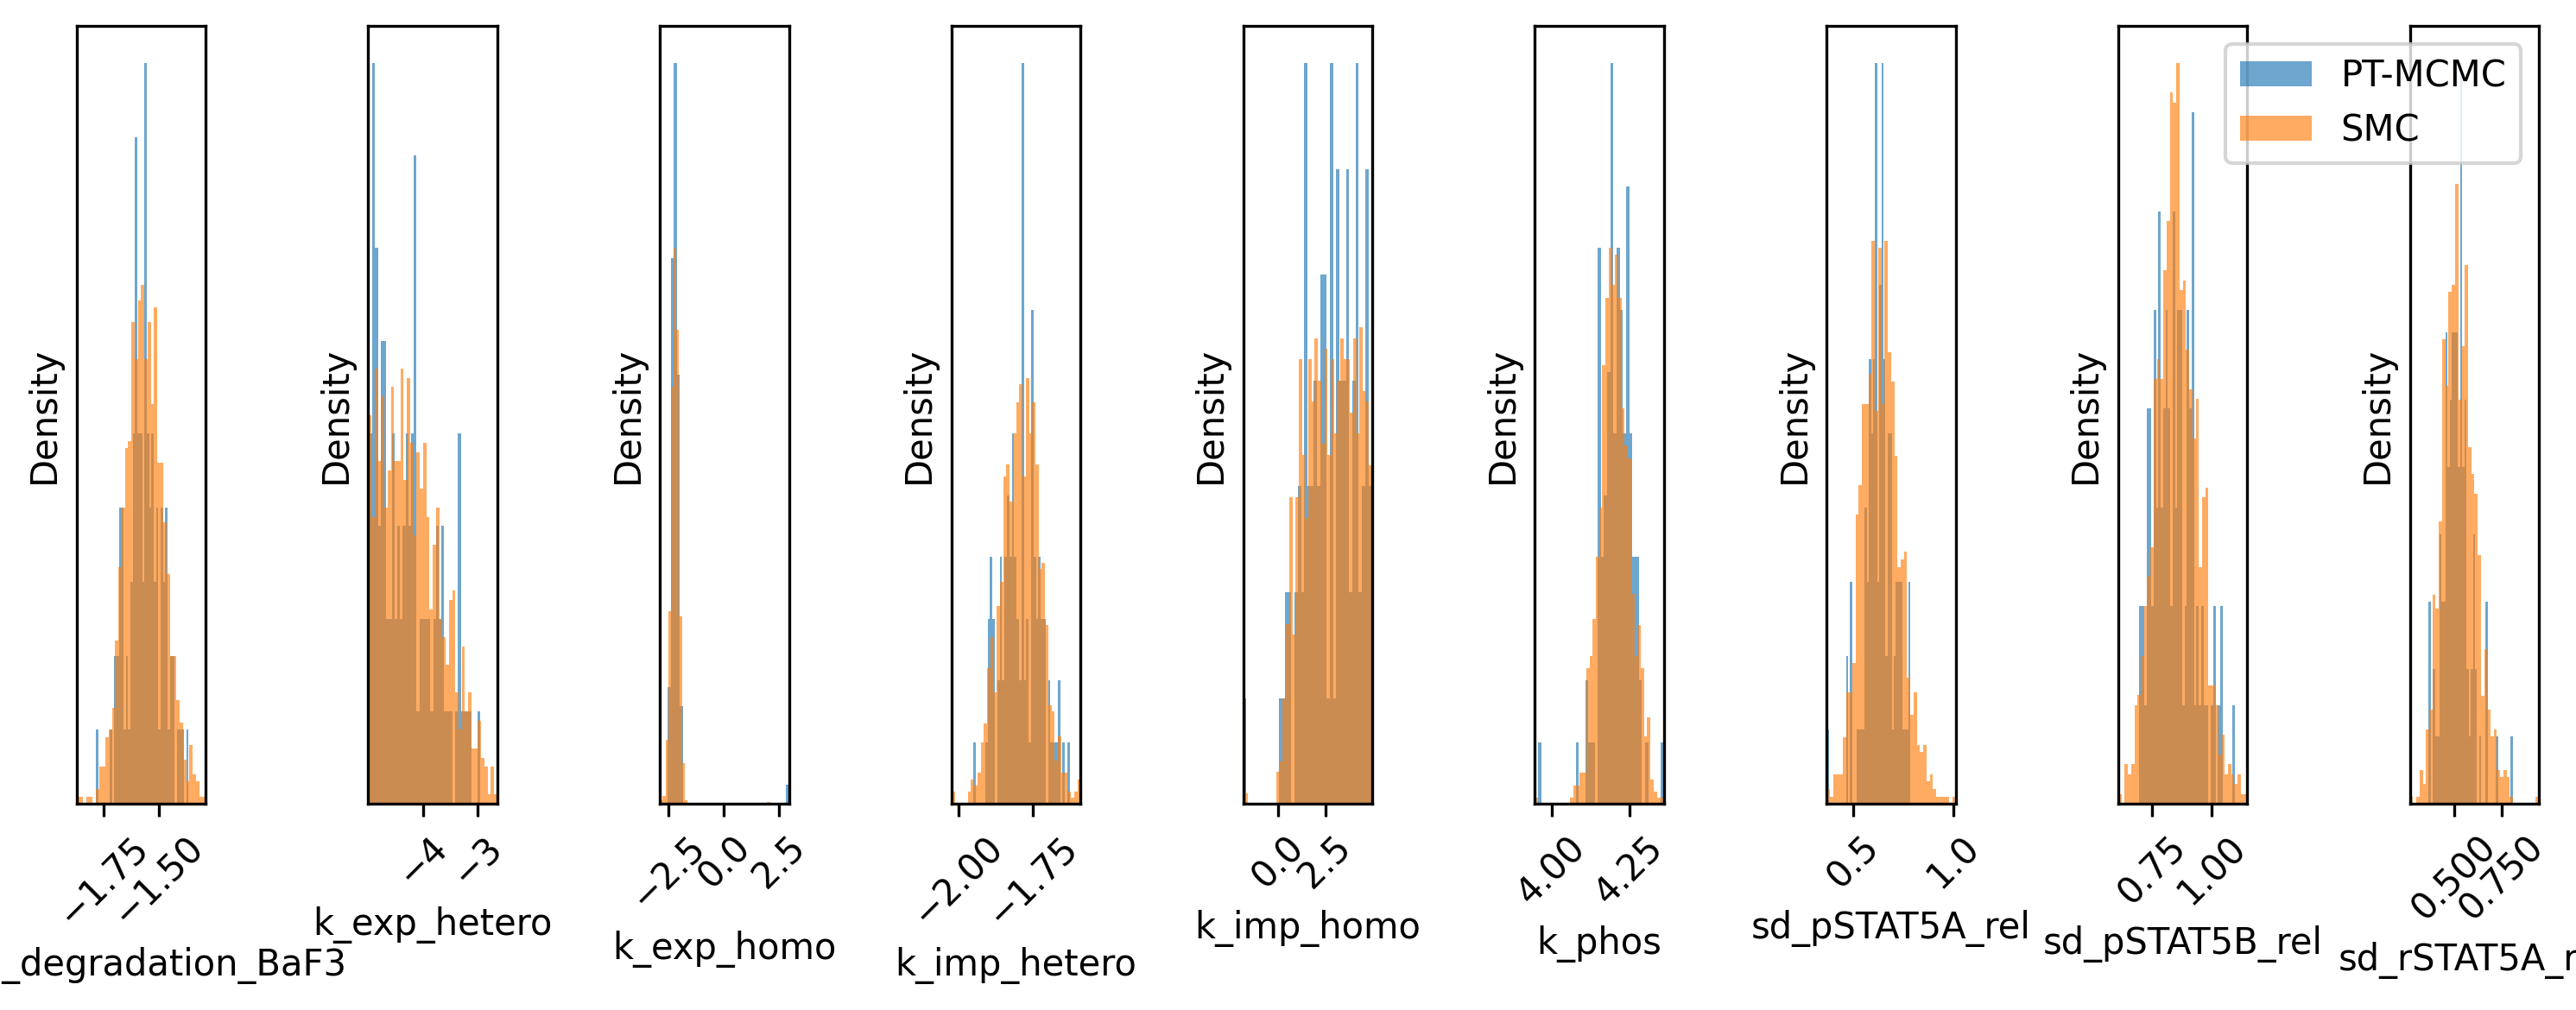

In [8]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
xtrue = mod_prob.petab_problem.get_x_nominal(fixed=False, scaled=False)
histtype = "bar"
alpha=0.65

plt.figure(figsize=(10,4), dpi=300)
for i, par_name in enumerate(fit_par_names): 
	plt.subplot(int(f"1{mod_prob.n_dim}{i+1}"))
	for j in range(len(best_results)):      
		cur_result = best_results[j]
		plt.hist(cur_result.posterior_samples[:, i], lw=2, weights=cur_result.posterior_weights, color=colors[j], alpha=alpha,
			 cumulative=False, histtype=histtype, bins=40, label=grouped_results[j].abbr) 
	#plt.axvline(x=xtrue[i], ls="--", color="k", label="Nominal", lw=0.75)
	plt.xlabel(par_name)
	plt.xticks(rotation=45)
	plt.yticks([])
	plt.ylabel("Density")
	plt.margins(x=0)
plt.legend()
plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

## Plot relationship between k1 and k2

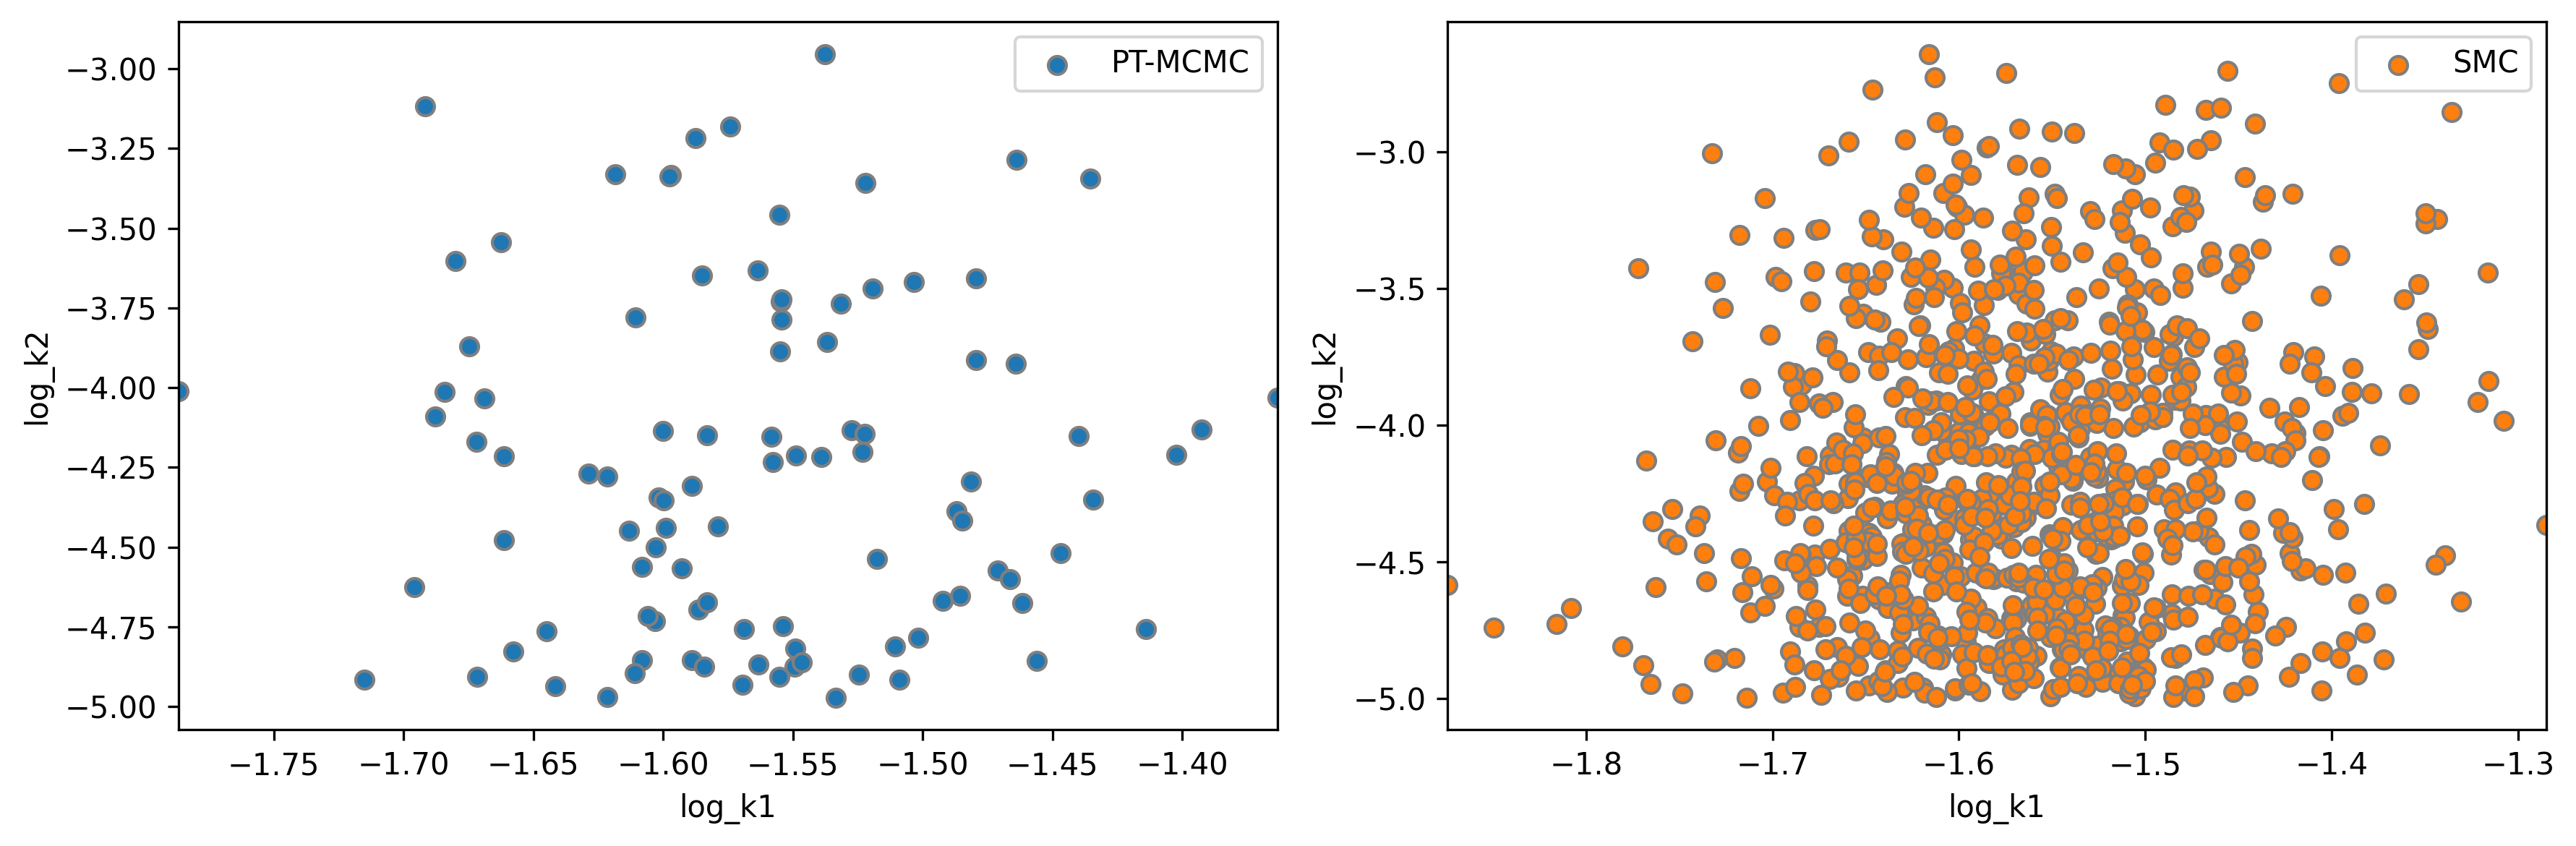

In [9]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds
histtype = "bar"
alpha=0.65

plt.figure(figsize=(12,4), dpi=300)
for j in range(len(best_results)): 
	plt.subplot(int(f"1{len(methods)}{j+1}"))     
	cur_result = best_results[j]
	plt.scatter(cur_result.posterior_samples[:, 0], cur_result.posterior_samples[:, 1], marker="o", 
			 edgecolors="tab:gray", lw=1, facecolor=colors[j], label=grouped_results[j].abbr) 
	plt.xlabel("log_k1")
	plt.ylabel("log_k2")
	plt.margins(x=0)
	plt.legend()
#plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

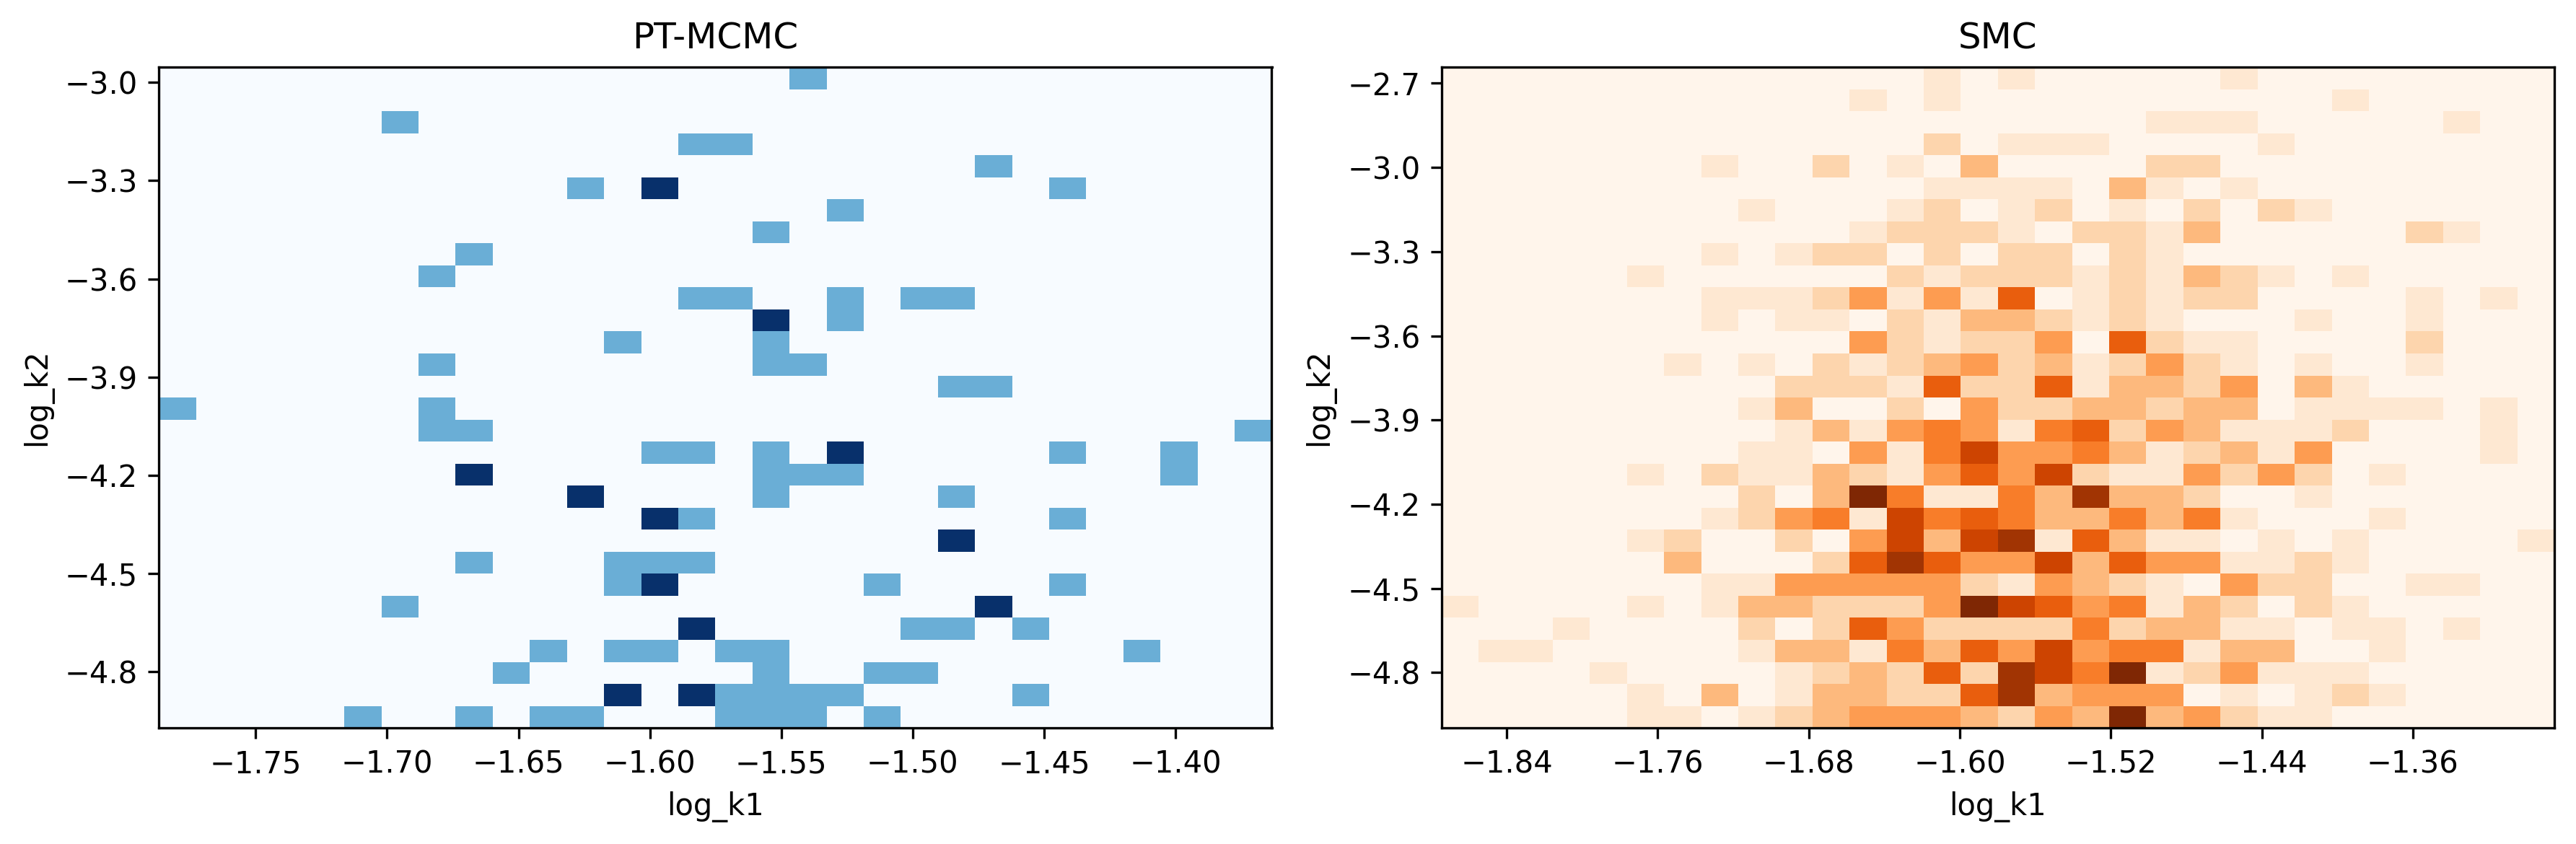

In [10]:
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

par_bounds = mod_prob.bounds

cmaps = ["Blues", "Oranges", "Greens"]
plt.figure(figsize=(12,4), dpi=300)
for j in range(len(best_results)): 
	plt.subplot(int(f"1{len(methods)}{j+1}"))     
	cur_result = best_results[j]
	plt.hist2d(cur_result.posterior_samples[:, 0], cur_result.posterior_samples[:, 1], bins=30, cmap=cmaps[j])
	plt.xlabel("log_k1")
	plt.ylabel("log_k2")
	plt.title(grouped_results[j].abbr)
	plt.gca().xaxis.set_major_locator(plt.MaxNLocator(9))
	plt.gca().yaxis.set_major_locator(plt.MaxNLocator(8))
#plt.gca().xaxis.set_major_formatter("{x:.3f}")
#plt.xlim(left=par_bounds[i][0], right=par_bounds[i][1])

plt.tight_layout()

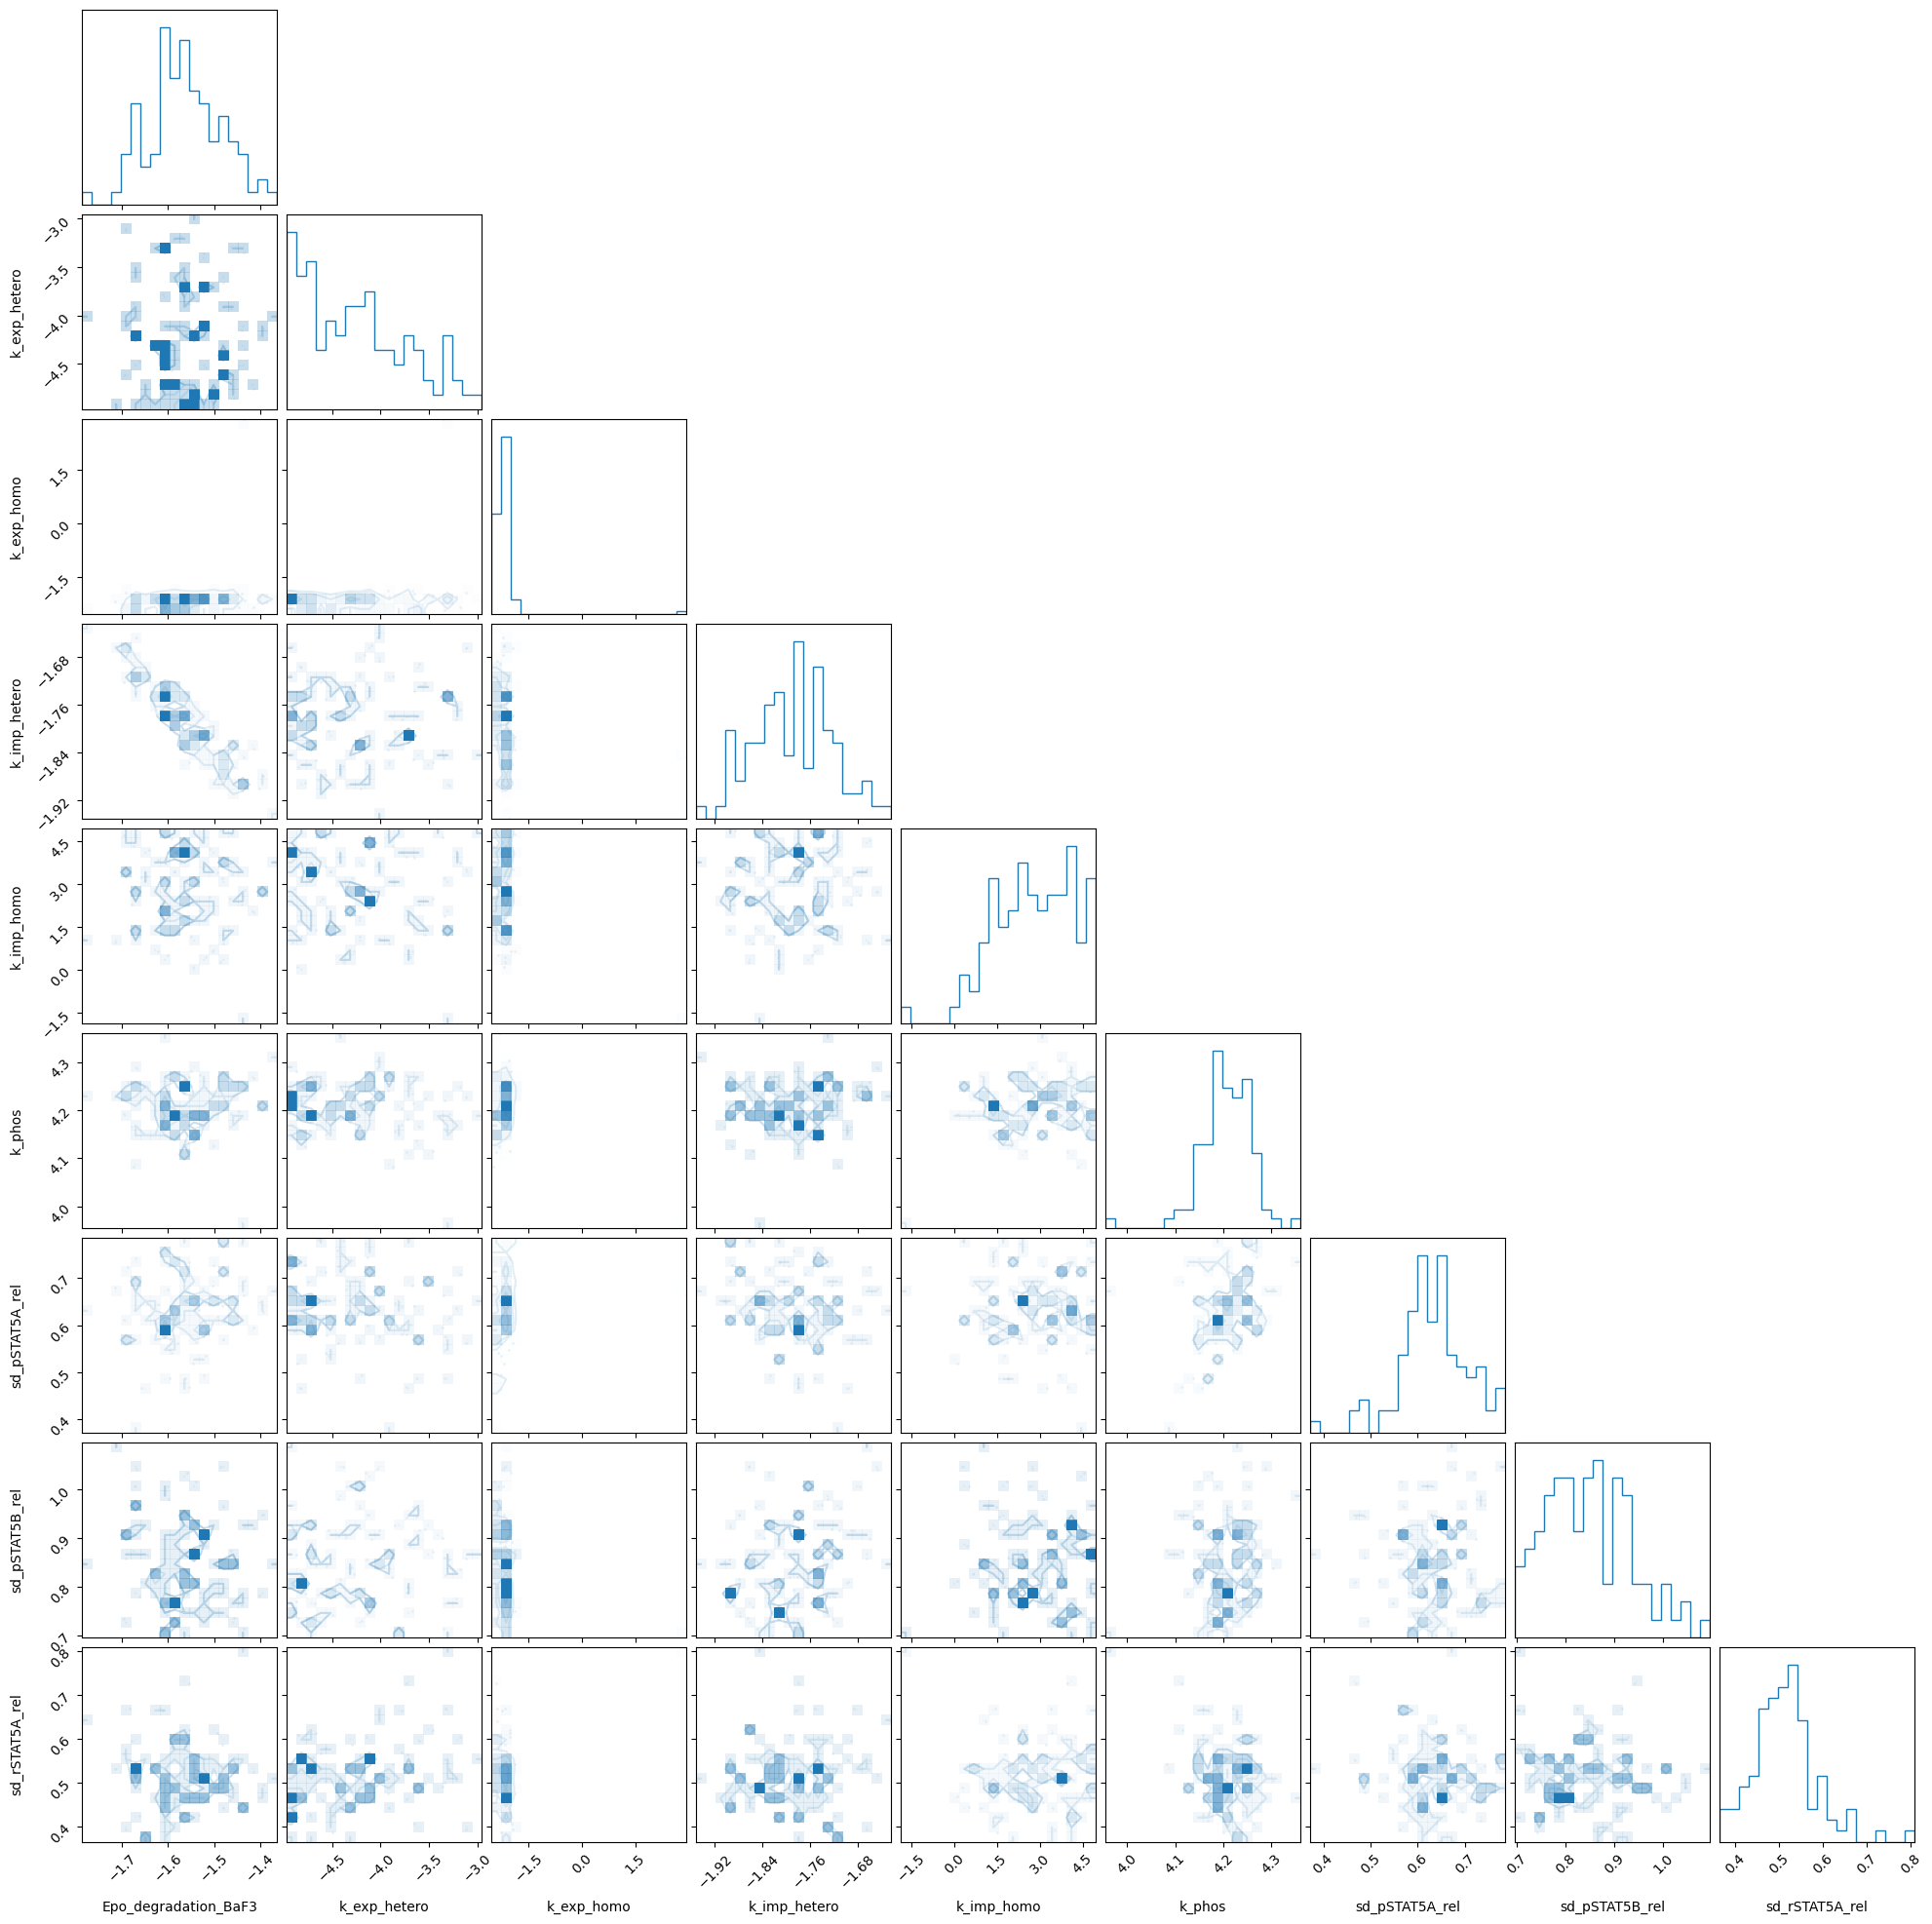

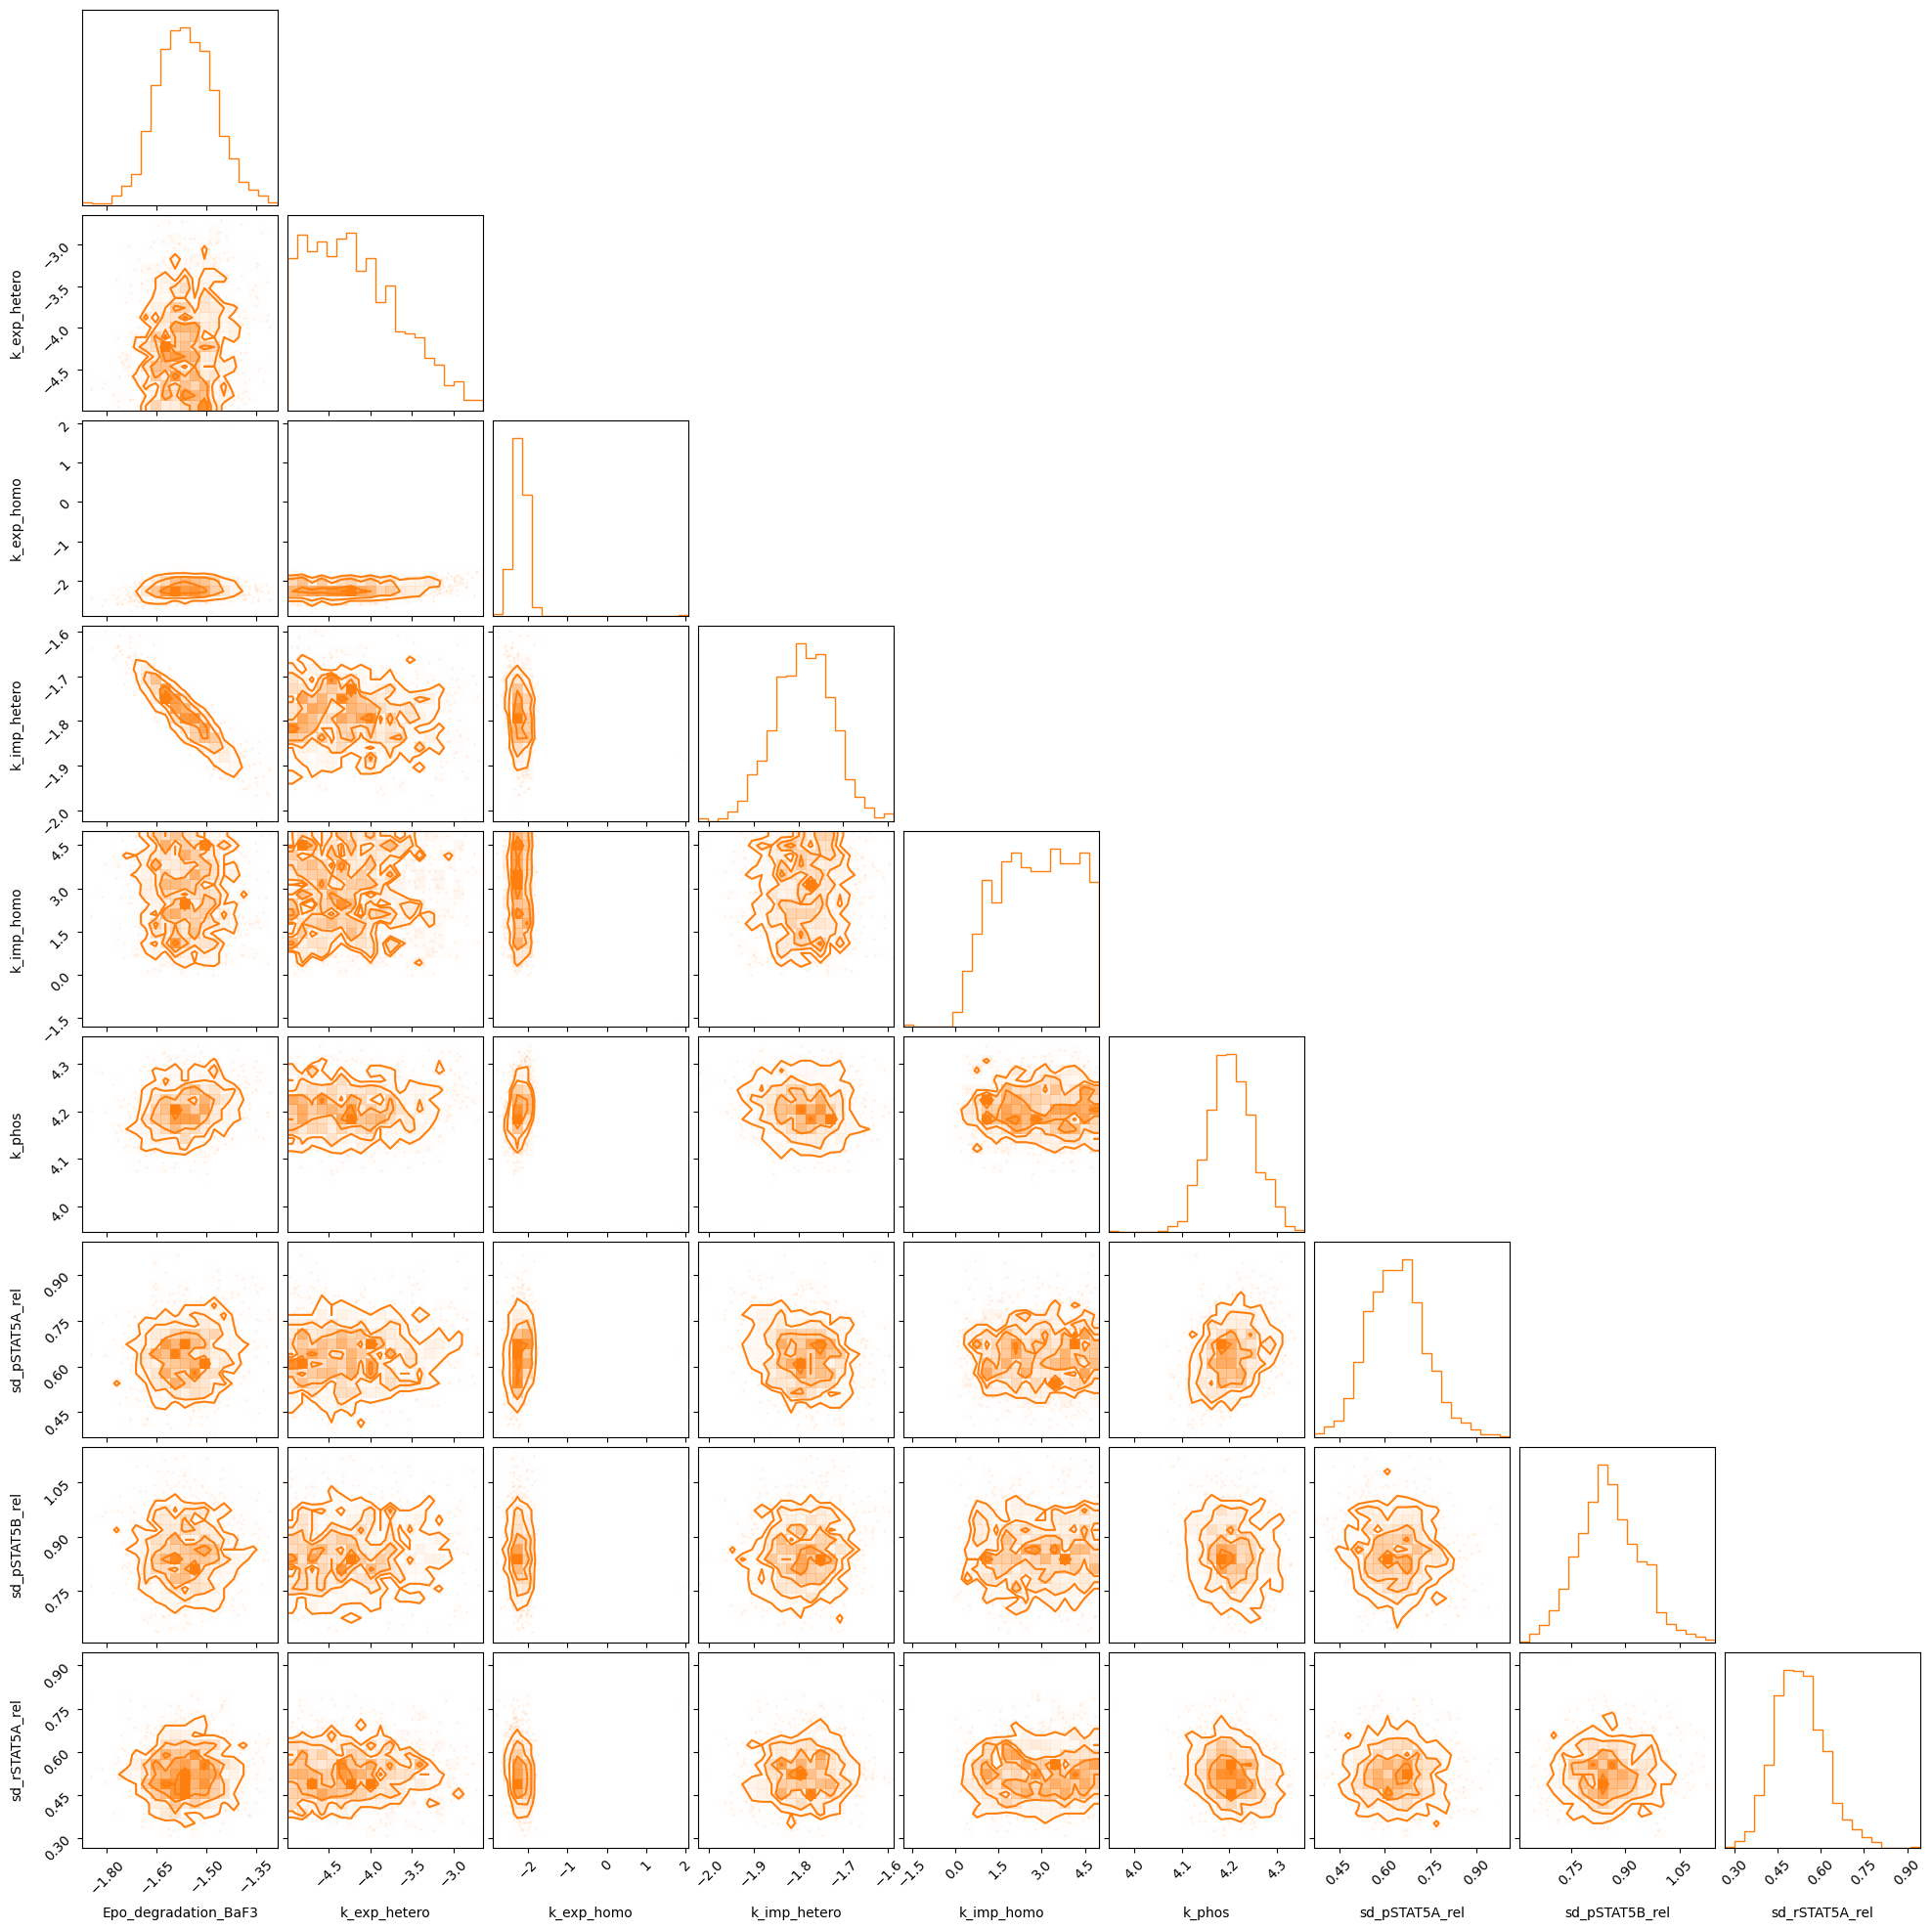

In [11]:
import corner
for i, method in enumerate(methods):
	cur_result = best_results[i]
	param_samples = cur_result.posterior_samples
	norm_ws = cur_result.posterior_weights #np.divide(cur_result.posterior_weights, np.sum(cur_result.posterior_weights))
	corner.corner(param_samples, weights=norm_ws, color=colors[i], labels=fit_par_names)
	

## Plot fits to model data

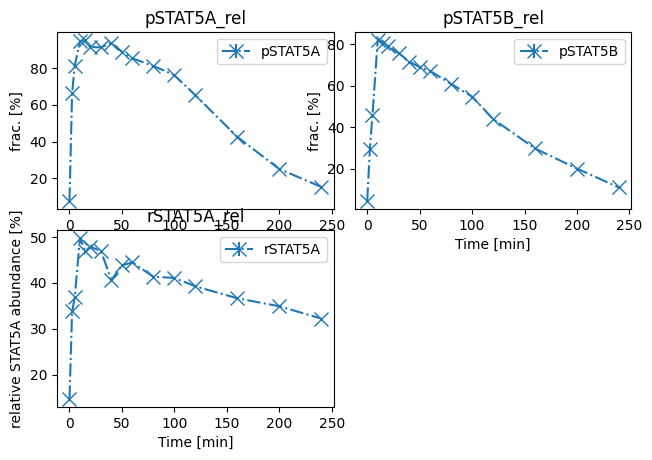

In [13]:
CI = 0.95
UPPER_PCT = (1 - (1-CI)/2)
LOWER_PCT = ((1-CI)/2)

petab_prob = mod_prob.petab_problem
ax_dict = plot_problem(petab_problem=petab_prob,) 
fig = plt.gcf()
# Change the figure size
fig.set_size_inches(6,4)

In [57]:
import petab
sds = petab.v1.measurements.get_measurement_parameter_ids(measure_df)
# Get the names of the estimated parameters
fixed_idxs = mod_prob.problem.x_fixed_indices
par_names = mod_prob.problem.x_names
x=np.array(par_names)
mask=np.full(len(par_names),True,dtype=bool)
mask[fixed_idxs]=False
fit_par_names=x[mask]

all_par_noms = mod_prob.petab_problem.x_nominal
sds_vals = [all_par_noms[list(par_names).index(x)] for x in sds]
for n,s in zip(sds, sds_vals):
	print(f"{n}: {s}")

obs = mod_prob.petab_problem.observable_df
obs_names = obs.index.values
obs_names

sd_pSTAT5A_rel: 3.85261197844677
sd_pSTAT5B_rel: 6.59147818673419
sd_rSTAT5A_rel: 3.15271275648527


array(['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel'], dtype=object)

In [62]:
measure_df

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParameters,datasetId
0,pSTAT5A_rel,NaN,model1_data1,7.901073,0.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
1,pSTAT5A_rel,NaN,model1_data1,66.363494,2.5,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
2,pSTAT5A_rel,NaN,model1_data1,81.171324,5.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
3,pSTAT5A_rel,NaN,model1_data1,94.730308,10.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
4,pSTAT5A_rel,NaN,model1_data1,95.116483,15.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
5,pSTAT5A_rel,NaN,model1_data1,91.441717,20.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
6,pSTAT5A_rel,NaN,model1_data1,91.257099,30.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
7,pSTAT5A_rel,NaN,model1_data1,93.672298,40.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
8,pSTAT5A_rel,NaN,model1_data1,88.754233,50.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel
9,pSTAT5A_rel,NaN,model1_data1,85.269703,60.0,NaN,sd_pSTAT5A_rel,model1_data1_pSTAT5A_rel


sd_pSTAT5A_rel: 0.5857552705999998
sd_pSTAT5B_rel: 0.8189828191999999
sd_rSTAT5A_rel: 0.49868440400000047
pSTAT5A_rel
(16, 100)
(16, 1000)
pSTAT5B_rel
(16, 100)
(16, 1000)
rSTAT5A_rel
(16, 100)
(16, 1000)


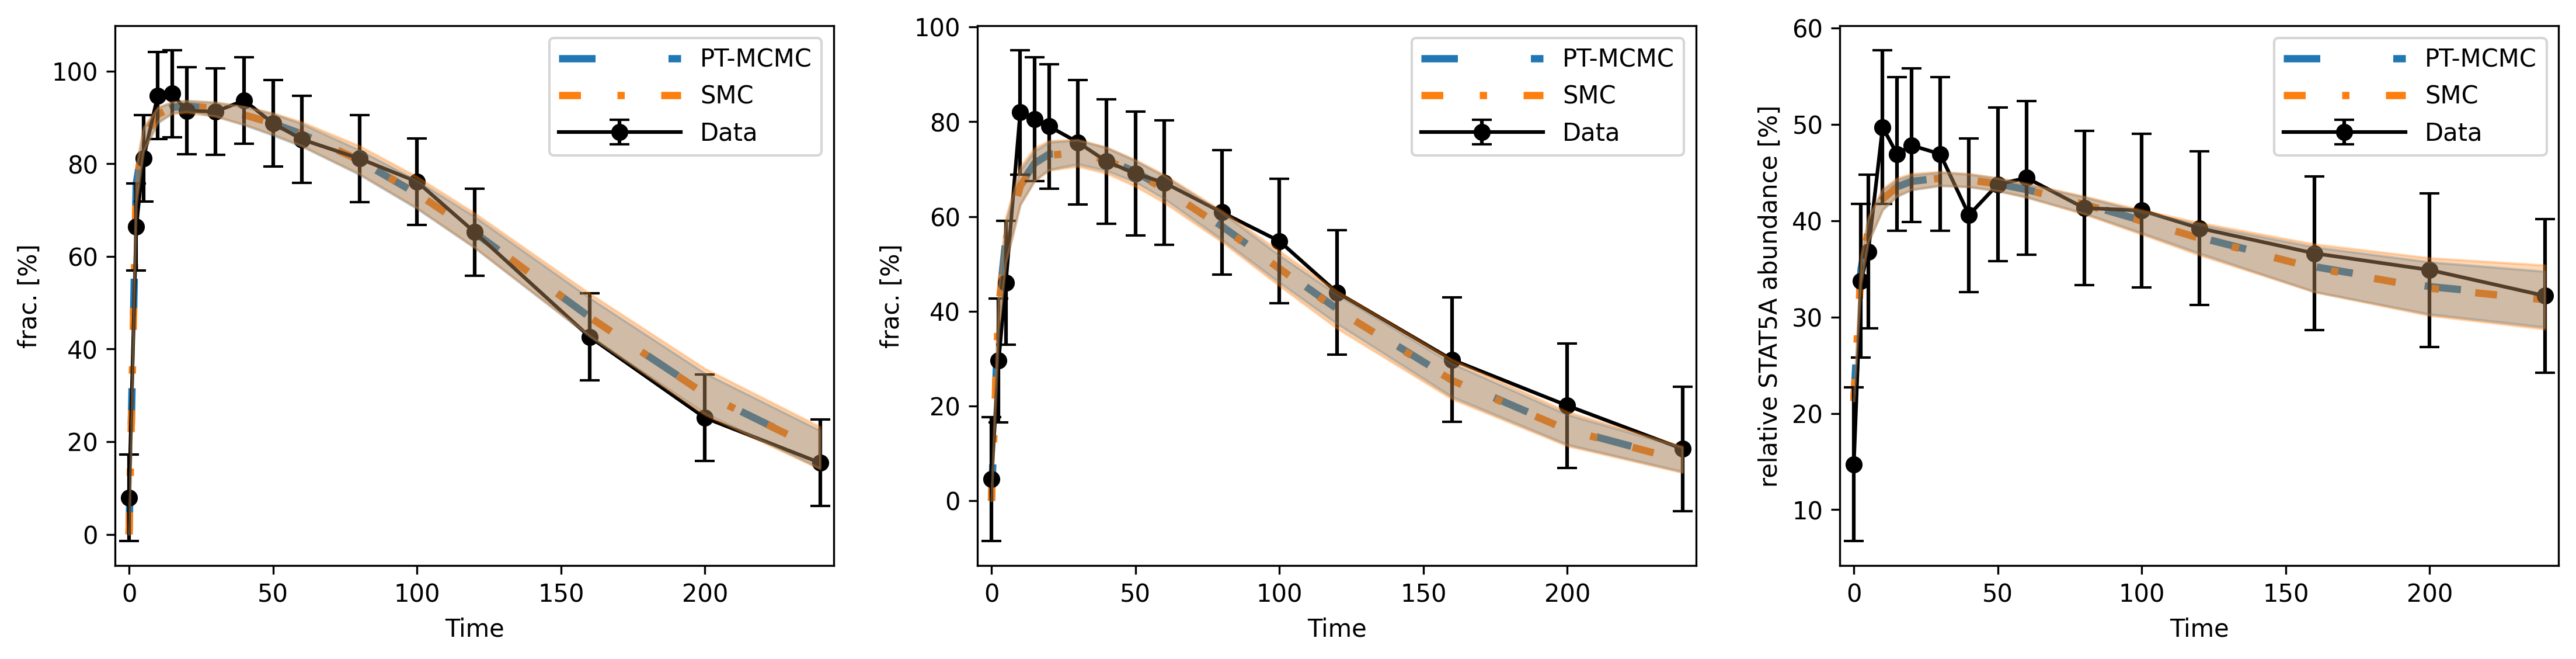

In [68]:
import petab
measure_df = petab_prob.measurement_df
sds = petab.v1.measurements.get_measurement_parameter_ids(measure_df)
# Get the names of the estimated parameters
par_names = mod_prob.problem.x_names

all_par_noms = mod_prob.petab_problem.x_nominal_scaled
sds_vals = [all_par_noms[list(par_names).index(x)] for x in sds]
for n,s in zip(sds, sds_vals):
	print(f"{n}: {s}")

obs = mod_prob.petab_problem.observable_df
obs_names = obs.index.values

obj = mod_prob.problem.objective
model = mod_prob.model

n_species = len(obs_names)
ylabs = ["frac. [%]", "frac. [%]", "relative STAT5A abundance [%]"]
plt.figure(figsize=(18,4), dpi=300)

for j, obs_name, ylab in zip(range(n_species), obs_names, ylabs):
	plt.subplot(int(f"1{n_species}{j+1}"))
	print(obs_name)
	obs_df = measure_df[measure_df["observableId"]==obs_name]

	plt.errorbar(obs_df["time"], obs_df["measurement"], 
					yerr=sds_vals[j]*16, color="k", marker="o", capsize=4, label="Data", zorder=2)
	lss = [(0,(5,10)), (0,(3,5,1,5)), (0,(1,4))]
	for i, best in enumerate(best_results):
		pars = best.posterior_samples
		weights = best.posterior_weights

		all_sim_data = np.empty(shape=(16, pars.shape[0]))
		print(all_sim_data.shape)
		## Collect all of the runs simulation information
		for n, par in enumerate(pars):
			sim = obj(par, mode="mode_fun", return_dict=True)#["simulation_results"]["simCondition"]
			#sim_df = amici.petab_objective.rdatas_to_simulation_df(
			#sim["rdatas"], model, measure_df)
			#print(sim.keys());
			#print(type(sim["rdatas"][0]))
			#print(list(sim["rdatas"][0].keys()))
			rdata = sim["rdatas"][0]

			#print(rdata.get("y").shape)
			all_sim_data[:, n] = rdata.get("y")[:,j]
			sim_ts = rdata.get("ts")
			
		n_ts = len(sim_ts)
		mean_sim_data = np.average(all_sim_data, weights=weights, axis=1)
		temp = np.array([weighted_quantile(x, [LOWER_PCT, UPPER_PCT], weights) for x in all_sim_data])
		#print(temp[0])
		low_sim_data = temp[:, 0]
		high_sim_data = temp[:, 1]

		plt.plot(sim_ts, mean_sim_data, lw=3, linestyle=lss[i], label=grouped_results[i].abbr, zorder=1, color=colors[i])
		plt.fill_between(sim_ts, low_sim_data, high_sim_data, zorder=3, alpha=0.3, color=colors[i])
	plt.legend(handlelength=5)
	plt.margins(x=0.02)
	plt.xlabel("Time"); plt.ylabel(ylab);